# Neuronal Networks and Deep Learning
    
## Stacked Denoising Autoencoder


by 

[__Michael Granitzer__ (michael.granitzer@uni-passau.de)]( http://www.mendeley.com/profiles/michael-granitzer/)

with examples taken from the scikit-learn documentation under http://scikit-learn.org/stable/


__License__

This work is licensed under a [Creative Commons Attribution 3.0 Unported License](http://creativecommons.org/licenses/by/3.0/)


# Introduction

This notebook outlines Stacked Denoising Autoencoders through small examples using python.

# Theory

TODO:

# Toy Example

In this toy example we will take a simple 2D circle and 3D sphere and learn it using a stacked denoising autoencoder.

In [1]:
%pylab inline
import numpy as np
import math
import pylab as pl
from mpl_toolkits.mplot3d import Axes3D
import mpld3
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize']=(14,6)

Populating the interactive namespace from numpy and matplotlib


## Data First: A Circle and a Sphere

In [2]:
def circle(r=[1.0, 1.0], num=1000, circle=False, seed=1357):
    d = np.zeros((2,num))
    state = np.random.RandomState(seed)
    for i in xrange(num):
        phi = 2*math.pi*state.rand() # x y angle
        d[0,i],d[1,i] = r[0]*math.cos(phi), r[1] * math.sin(phi)
    return d

def sphere(r=[1.0, 1.0, 1.0], num=1000, circle=False, seed=1357):
    d = np.zeros((3, num))
    state = np.random.RandomState(seed)
    for i in xrange(num):
        phi = 2*math.pi*state.rand() # x y angle
        theta = 2*math.pi*state.rand() # x y angle
        sin_theta = math.sin(theta)
        d[1,i],d[0,i],d[2,i] =r[1] * sin_theta * math.sin(phi) , r[0] * sin_theta* math.cos(phi), r[2]*math.cos(theta)
    return d

def scatter3D(data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[0], data[1], data[2])
    return fig

def plotae(ae, data):
    pass

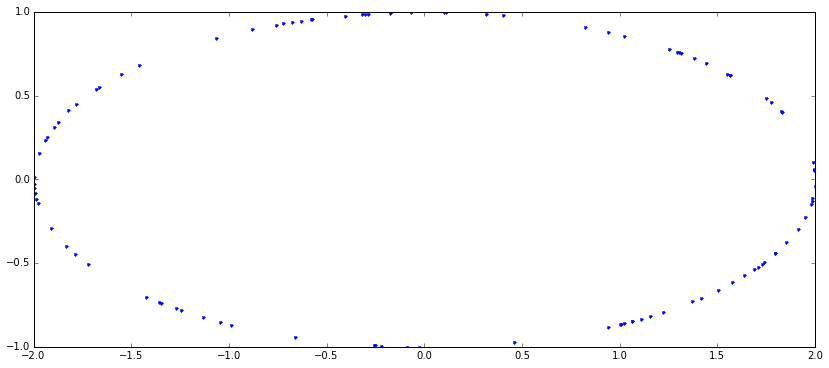

In [7]:
d = circle([2.0,1.0],100)
pl.plot(d[0,],d[1,],".")
pl.show()

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


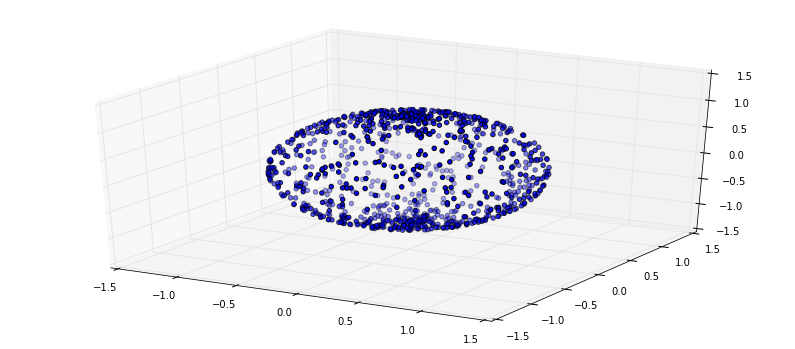

In [9]:
data = sphere([1.0,1.0,1.0],1000)
scatter3D(data).show()

## The Autoencoder

The 'tanh' function as non-linear output scaling transfer function:

$$
o(x) = \frac{e^{wx} - e^{-{wx}}}{e^{wx} + e^{-{wx}}}
$$

Backpropagation training consists of (see training_step_stochastic for the implementation)

1. calculating the encoding of an example $x$ based on the model with Weights $W$ and bias $b$ as 
$$
y = o_{W,b}(x)
$$
2. reconstructing the example $x$ based on the model with Weights $W^T$ and bias $b'$ as
$$
z = o_{W^{t},b'}(y)
$$
3. calculating the error between example $x$ and reconstruction of $x$ as
$$
\delta_o = (x-z)
$$
4. updating the model by going from the reconstructed output $z$ to the hidden layer representation $y$ to the input layer $x$  
   - Output Layer:
        $$
        b'= b'+ \eta * (1-z^2) * \delta_o
        $$
        $$
        W.T= W.T + \eta * ((1-z^2) \cdot \delta_o) * y^T
        $$
   - Hidden Layer with error $\delta_h = (W * \delta_o) * (1-z^2)$
   $$
    b = b + \eta * (1-y^2) * \delta_h
   $$
   $$
    W = W + \eta * ((1-y^2) \cdot \delta_h)*x^T
    $$

see [backprop description](http://www.willamette.edu/~gorr/classes/cs449/backprop.html) for details. Note the difference between $\cdot$ as Pointwise prodcut and $*$  as matrix multiplication.


In [3]:
class Autoencoder(object):

    def __init__(self, in_size, hidden_size):
        self.w = np.random.random((hidden_size, in_size))
        self.b = np.random.random(hidden_size)
        self.b_rec = np.random.random(in_size)
        
    def out(self, x,w,b):
        # function that calculates the output of the network
        wx = np.sum(x * w,1) +b
        e_x = np.exp(wx)
        e_mx = np.exp(-1.0*wx)
        return (e_x-e_mx)/(e_x+e_mx)

    def encode(self, x): 
        return self.out(x,self.w,self.b)

    def decode(self, x): 
        return self.out(x,self.w.T,self.b_rec)

    def endecode(self, x):
        return self.decode(self.encode(x))
    
    def train_step_stochastic(self, x, eta=0.1):
        # todo: use elastic for learning
        # data is a 1d array with exactly 1 example
        # forward phase
        y = self.encode(x) # input to hidden layer activation
        z = self.decode(y) # hidden layer to output layer activation. Note that the weights are shared
        err = x - z # error at the ouput layer
        self.b_rec = self.b_rec + eta * (1 - z**2) * err # update the bias terms into the reconstruction layer
        dwt = eta * np.matrix(((1 - z**2) * err)).T * np.matrix(y)  # a matrix update. one row for every neuron in the hidden layer
        err_h = np.sum(self.w * err,1)  # error of the hidden layer.
        self.b = self.b + eta * (1 - y**2) * err_h # update the bias terms into the hidden layer.
        self.w = self.w + np.asarray(eta * np.matrix((1 - y**2) * err_h).T * np.matrix(x) + dwt.T) #
        return err
    
   
    def train(self, data, epochs=20, eta=0.1, callback=None):
        for j in xrange(epochs):
            sum_err = 0
            for i in xrange(data.shape[1]):
                err = self.train_step_stochastic(data[:,i], eta)
                sum_err += np.sum(err**2)/data.shape[1]
            if callback!=None:
                callback(j,sum_err)
        return self
    
    def decode_all(self, data):
        return np.array([self.decode(x) for x in data.T]).T
    
    def encode_all(self, data):
        return np.array([self.encode(x) for x in data.T]).T

    def plot(self,data, hidden_grid=False):
        if data.shape[0]==2:
            hidden = self.encode_all(data) #np.array([encode(x,w,b,b_rec) for x in data.T]).T
            if hidden_grid:
                hidden = np.linspace(-2,2,data.shape[1])
            reconstructed = self.decode_all(hidden) # np.array([decode(x,w,b,b_rec) for x in hidden.T]).T
            # plot the encoded points
            fig, ax = plt.subplots(1,2)
            ax[0].plot(data[0],data[1],".")
            ax[0].set_title("data")
            pts = ax[1].scatter(reconstructed[0], reconstructed[1], marker="+", c=hidden, cmap=cm.bwr )
            ax[1].set_title("reconstruction")
            colorbar(pts)
            return fig
        else:
            return None
    
    
def cb_print(epoch,sse):
    if epoch%5==0:
        print(epoch, " sse=",sse)  

### Training and Testing on a circle

**Circle:** The first experiment is a simple circle reduced to a 1D space. We can see that the hidden unit encodes a diameter. the direction depends on the initatlization and since there is no ability for reconstruction, the network can only retain 1 direction.

(0, ' sse=', 0.16708995374821423)
(5, ' sse=', 0.12711896254849181)
(10, ' sse=', 0.1269777808928067)
(15, ' sse=', 0.12685460437837245)
(20, ' sse=', 0.12674734387937561)
(25, ' sse=', 0.12665355375156018)
(30, ' sse=', 0.12657094152214907)
(35, ' sse=', 0.12649752312423665)


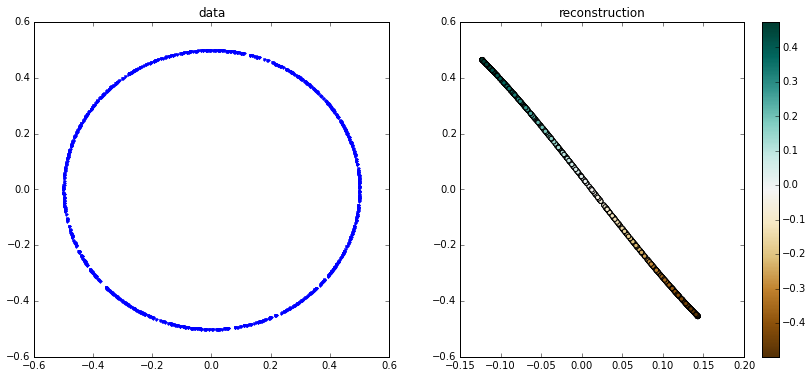

In [12]:
data = circle([0.5,0.5],1000)
ae = Autoencoder(data.shape[0],1)
ae.train(data, epochs=40, callback = cb_print, eta=0.01)
ae.plot(data).show()

**Eclipse:** next we try an eclipse. The cirlce is streched in  on direction. This direction has the greatest variance and the network should capture that direction. 

(0, ' sse=', 0.1271092592612931)
(5, ' sse=', 0.0056445687662943118)
(10, ' sse=', 0.0056219023470761463)
(15, ' sse=', 0.0056006144463505575)
(20, ' sse=', 0.0055806267548486818)
(25, ' sse=', 0.0055618393100177821)
(30, ' sse=', 0.0055441615004470871)
(35, ' sse=', 0.005527511160851247)


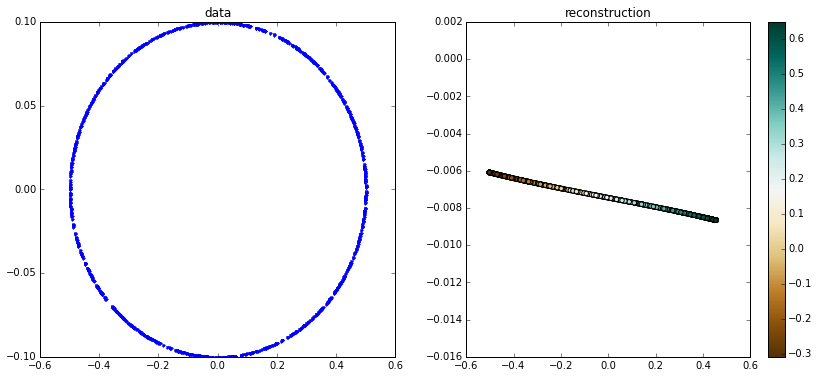

In [619]:
data = circle([0.5,0.1],1000)
ae = Autoencoder(data.shape[0],1)
ae.train(data, epochs=40, callback = cb_print, eta=0.01)
ae.plot(data).show()

(0, ' sse=', 0.11699069639392981)
(5, ' sse=', 0.0053911996250388308)


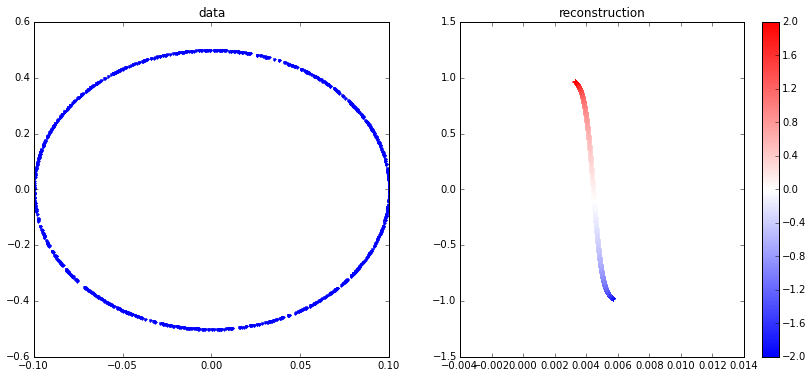

In [79]:
data = circle([0.1,0.5],1000)
ae = Autoencoder(data.shape[0],1)
ae.train(data, epochs=10, callback = cb_print, eta=0.01)
ae.plot(data,True).show() #show the full range of hidden units

In [63]:
np.linspace(-1,1,100)

array([-1.        , -0.97979798, -0.95959596, -0.93939394, -0.91919192,
       -0.8989899 , -0.87878788, -0.85858586, -0.83838384, -0.81818182,
       -0.7979798 , -0.77777778, -0.75757576, -0.73737374, -0.71717172,
       -0.6969697 , -0.67676768, -0.65656566, -0.63636364, -0.61616162,
       -0.5959596 , -0.57575758, -0.55555556, -0.53535354, -0.51515152,
       -0.49494949, -0.47474747, -0.45454545, -0.43434343, -0.41414141,
       -0.39393939, -0.37373737, -0.35353535, -0.33333333, -0.31313131,
       -0.29292929, -0.27272727, -0.25252525, -0.23232323, -0.21212121,
       -0.19191919, -0.17171717, -0.15151515, -0.13131313, -0.11111111,
       -0.09090909, -0.07070707, -0.05050505, -0.03030303, -0.01010101,
        0.01010101,  0.03030303,  0.05050505,  0.07070707,  0.09090909,
        0.11111111,  0.13131313,  0.15151515,  0.17171717,  0.19191919,
        0.21212121,  0.23232323,  0.25252525,  0.27272727,  0.29292929,
        0.31313131,  0.33333333,  0.35353535,  0.37373737,  0.39

### Training a sphere

(2, 3)
(0, ' sse=', 0.33660251971748589)
(5, ' sse=', 0.26611609029791189)
(10, ' sse=', 0.26611817696075846)
(15, ' sse=', 0.26611817680956901)


/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


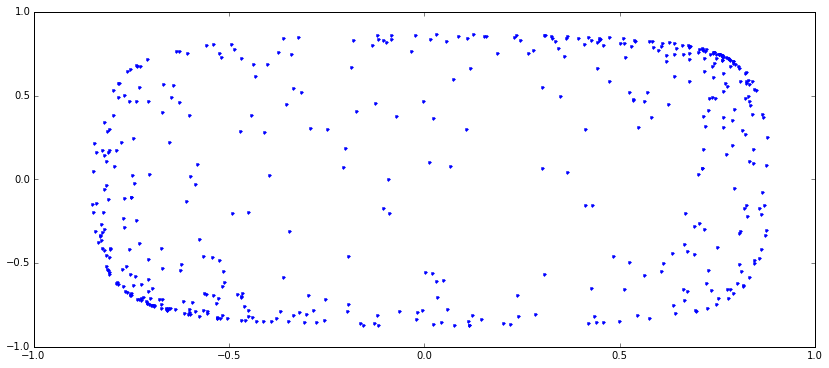

In [4]:
data = sphere([1.0,1.0,1.0],500)
ae = Autoencoder(data.shape[0],2)
print ae.w.shape
ae.train(data, epochs=20, callback = cb_print)
hidden = ae.encode_all(data) #np.array([encode(x,w,b,b_rec) for x in data.T]).T
reconstructed = ae.decode_all(hidden) # np.array([decode(x,w,b,b_rec) for x in hidden.T]).T
# plot the encoded points
fig, ax = plt.subplots()
ax.plot(hidden[0],hidden[1],".")
fig.show()

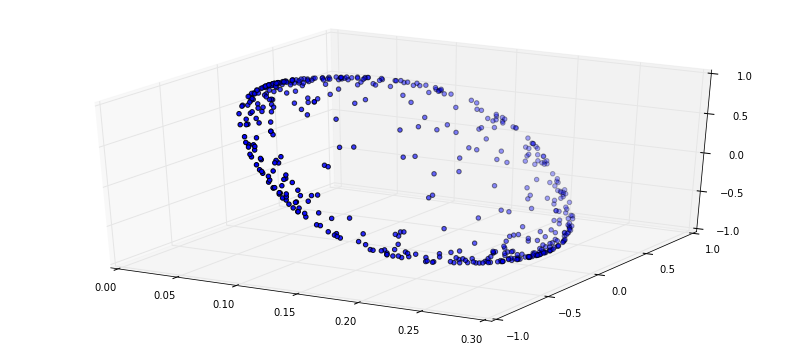

In [622]:
#show the reconstructed examples. 
scatter3D(reconstructed).show()

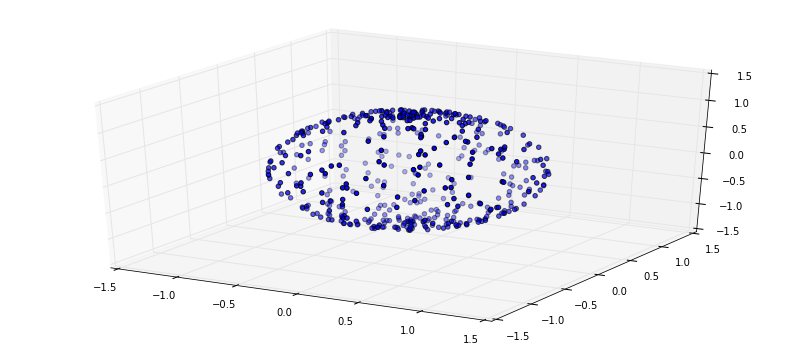

In [623]:
#and the original data
scatter3D(data).show()

### Bi-Spherical Data 

The following data set shows an interesting example. We have two eliptic spheres. Sphere 1 has a larger radius in the x-direction while sphere 2 has a larger radius in z-direction. The embedding tries to account for both directions, but since it only can embedd in a 2D space the reconstruction gets skewed in 3D. Note also that the reconstruction is not a real 3D, but the 2D images projected into 3D.

(0, ' sse=', 0.0067973771228142278)
(5, ' sse=', 0.0033030721378499374)
(10, ' sse=', 0.0032643530575083811)
(15, ' sse=', 0.0032346870615532139)


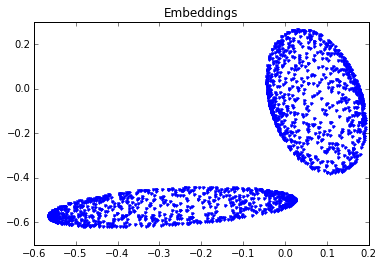

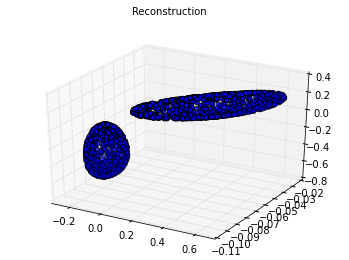

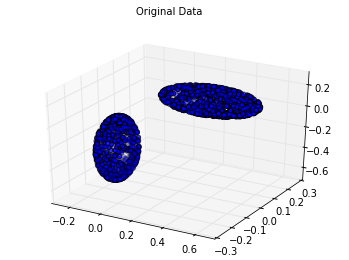

In [58]:
data = sphere([0.3,0.1,0.1], 1000) + [[0.3],[0.1],[0.1]]
data2 = sphere([0.1,0.1,0.3], 1000) - [[0.1],[0.1],[0.3]]
data = np.append(data, data2, axis=1)
ae = Autoencoder(data.shape[0],2)
ae.train(data, epochs=20, callback = cb_print)
hidden = ae.encode_all(data) #np.array([encode(x,w,b,b_rec) for x in data.T]).T
reconstructed = ae.decode_all(hidden) # np.array([decode(x,w,b,b_rec) for x in hidden.T]).T
# plot the encoded points
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(hidden[0],hidden[1],".")
ax.set_title("Embeddings")
fig.show()
fig = scatter3D(reconstructed)
fig.suptitle("Reconstruction")
fig.show()
fig=scatter3D(data)
fig.suptitle("Original Data")
fig.show()

In [56]:
data = sphere([0.4,0.1,0.1], 1000) + [[0.4],[0.1],[0.1]]
data2 = sphere([0.1,0.4,0.1], 1000) - [[0.1],[0.4],[0.1]]
data = np.append(data, data2, axis=1)
ae = Autoencoder(data.shape[0],2)
ae.train(data, epochs=20, callback = cb_print)
hidden = ae.encode_all(data) #np.array([encode(x,w,b,b_rec) for x in data.T]).T
reconstructed = ae.decode_all(hidden) # np.array([decode(x,w,b,b_rec) for x in hidden.T]).T
# plot the encoded points
fig, ax = plt.subplots()
ax.plot(hidden[0],hidden[1],".")
ax.set_title("Embeddings")
fig.show()
%matplotlib
fig = scatter3D(reconstructed)
fig.suptitle("Reconstruction")
fig.show()
fig=scatter3D(data)
fig.suptitle("Original Data")
fig.show()
%matplotlib inline
print "take a look at the windows opened"

(0, ' sse=', 0.020854960423501819)
(5, ' sse=', 0.0067076198799650285)
(10, ' sse=', 0.0069205961775444923)
(15, ' sse=', 0.0070303206826853905)
Using matplotlib backend: MacOSX


## Training and testing elastic learning

In elastic learning we train one neuron after another and expand the hidden layer size elastically. 
In the implementation here we do this in an inefficent way: we just set the error for a neuron to 0, thereby masking its error and prohibiting backprop updates. Similarly we mask the output of a neuron in the forward step by setting it to 0. Note that this only works with $\tanh$ since $\tanh(0)=0$. 

It is a inefficient way to do this, since we calculate the full matrix in every training step. For imporving efficiency one would need to cache internal hidden layer states ($y$) and reconstruction ($z$) per example.

Software technical the following code does a monkey patch to the Autoencoder class.

In [15]:
def train_step_stochastic_elastic(self, x, fwd_mask, err_mask, eta=0.1):
    # data is a 1d array with exactly 1 example
    # forward phase
    y = self.encode(x) # input to hidden layer activation
    if self.log_elastic > 2: print "forward mask", y, y*fwd_mask, type(y), type(y*fwd_mask)
    y = y * fwd_mask   # mask the network forward step
    z = self.decode(y) # hidden layer to output layer activation. Note that the weights are shared
    # the error mask only activates a certain output
    err = (x - z) # error at the ouput layer
    self.b_rec = self.b_rec + eta * (1 - z**2) * err # update the bias terms into the reconstruction layer
    dwt = eta * np.matrix(((1 - z**2) * err)).T * np.matrix(y)  # a matrix update. one row for every neuron in the hidden layer
    err_h = np.sum(self.w * err,1)  # error of the hidden layer.
    if self.log_elastic > 2: print "backprop mask", err_h, err_h*err_mask
    err_h = err_h*err_mask
    self.b = self.b + eta * (1 - y**2) * err_h # update the bias terms into the hidden layer.
    self.w = self.w + np.asarray(eta * np.matrix((1 - y**2) * err_h).T * np.matrix(x) + dwt.T) #
    return err

def train_elastic(self, data, epochs=20, eta=0.1, callback=None):
    for h in xrange(self.w.shape[0]): #iterate over hidden nodes
        err_mask = np.zeros(self.w.shape[0]) # error mask determines which neuron is trained
        err_mask[h] = 1.0
        fwd_mask = np.zeros(self.w.shape[0])
        fwd_mask[:h+1] = 1.0
        if self.log_elastic>0 : print "training hidden neuron ", h, " with err mask", err_mask," and fwd mask",  fwd_mask
        for j in xrange(epochs):
            sum_err = 0
            for i in xrange(data.shape[1]):
                err = self.train_step_stochastic_elastic(data[:,i], fwd_mask, err_mask, eta)    
                sum_err += np.sum(err**2)/data.shape[1]
            if callback!=None:
                callback(j,sum_err)
    return self    

#Monkey patch the autoencoder
Autoencoder.train_step_stochastic_elastic = train_step_stochastic_elastic
Autoencoder.train_elastic = train_elastic
Autoencoder.log_elastic = 0

### Functional test of elastic learning

(0, ' sse=', 0.12591367100206682)
IT WORKS!!!!!!!


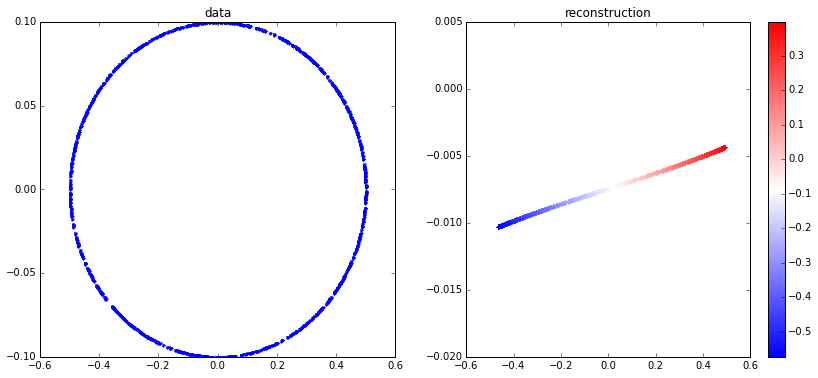

In [7]:
#nothing should change for a single hidden unit
Autoencoder.log_elastic = 1
data = circle([0.5,0.1],1000)
ae = Autoencoder(data.shape[0],1)
ae.train_elastic(data, epochs=5, callback = cb_print, eta=0.01)
ae.plot(data).show()
print "IT WORKS!!!!!!!"

training hidden neuron  0  with err mask [ 1.  0.]  and fwd mask [ 1.  0.]
(0, ' sse=', 0.59073944529515732)
(5, ' sse=', 0.54688555967235275)
training hidden neuron  1  with err mask [ 0.  1.]  and fwd mask [ 1.  1.]
(0, ' sse=', 0.29077167905627832)
(5, ' sse=', 0.26634023786866473)


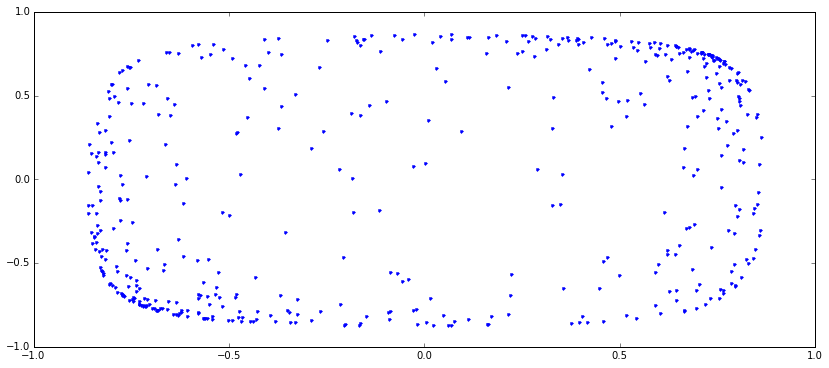

In [12]:
Autoencoder.log_elastic = 1
data = sphere([1.0,1.0,1.0],500)
ae = Autoencoder(data.shape[0],2)
ae.train_elastic(data, epochs=10, callback = cb_print)
hidden = ae.encode_all(data) #np.array([encode(x,w,b,b_rec) for x in data.T]).T
reconstructed = ae.decode_all(hidden) # np.array([decode(x,w,b,b_rec) for x in hidden.T]).T
# plot the encoded points
fig, ax = plt.subplots()
ax.plot(hidden[0],hidden[1],".")
fig.show()

training hidden neuron  0  with err mask [ 1.  0.]  and fwd mask [ 1.  0.]
(0, ' sse=', 0.027263031245047583)
(5, ' sse=', 0.017427415012147528)
(10, ' sse=', 0.017496289533074038)
(15, ' sse=', 0.017503086340231344)
training hidden neuron  1  with err mask [ 0.  1.]  and fwd mask [ 0.  1.]
(0, ' sse=', 0.021704172564318974)
(5, ' sse=', 0.017362426496012735)
(10, ' sse=', 0.017490217519854571)
(15, ' sse=', 0.017502466608059559)


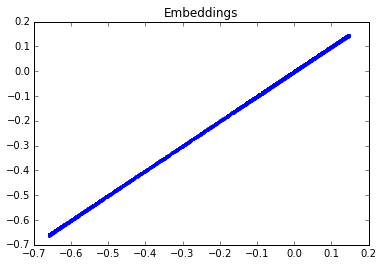

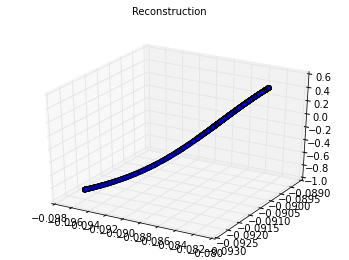

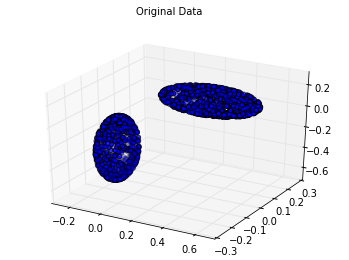

In [16]:
Autoencoder.log_elastic = 1
data = sphere([0.3,0.1,0.1], 1000) + [[0.3],[0.1],[0.1]]
data2 = sphere([0.1,0.1,0.3], 1000) - [[0.1],[0.1],[0.3]]
data = np.append(data, data2, axis=1)
ae = Autoencoder(data.shape[0],2)
ae.train_elastic(data, epochs=20, callback = cb_print)
hidden = ae.encode_all(data) #np.array([encode(x,w,b,b_rec) for x in data.T]).T
reconstructed = ae.decode_all(hidden) # np.array([decode(x,w,b,b_rec) for x in hidden.T]).T
# plot the encoded points
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(hidden[0],hidden[1],".")
ax.set_title("Embeddings")
fig.show()
fig = scatter3D(reconstructed)
fig.suptitle("Reconstruction")
fig.show()
fig=scatter3D(data)
fig.suptitle("Original Data")
fig.show()

### Functional Testing stuff (deprecated) 

In [503]:
data = sphere([1.0,1.0,1.0],1)[:,0]
print data
w = np.array([[0.1,0.2,0.3], [0.2, 0.3, 0.4]])
b = np.array([0.3, 0.4])
b_rec = np.array([0.3, 0.4, 0.5])
eta = 0.1
ys = out(data,w,b) # input to hidden layer activatio
zs = out(ys,w.T,b_rec) # hidden layer to output layer activation. Note that the weights are shared
err = data.T - zs # error at the ouput layer    
b_rec_n = b_rec + eta * (1 - zs**2) * err # update the bias terms into the reconstruction layer
dwt = eta * np.matrix(((1 - zs**2) * err)).T * np.matrix(ys) 
err_h = np.sum(w * err,1)
b = b + eta * (1 - ys**2) * err_h
w = w + eta * np.matrix((1 - ys**2) * err_h).T * np.matrix(data) #

[-0.78008208 -0.625526   -0.01375399]


In [505]:
print w.shape
print data.shape


(2, 3)
(3,)


In [509]:
print w, type(w)

[[ 0.13631487  0.22911988  0.30064028]
 [ 0.25704243  0.34574073  0.40100574]] <class 'numpy.matrixlib.defmatrix.matrix'>


In [508]:
print data, type(data)

[-0.78008208 -0.625526   -0.01375399] <type 'numpy.ndarray'>
